In [1]:
import sys,os

In [2]:
# sys.path.append("/opt/notebooks/GPU-GWAS/")
# os.chdir("/opt/notebooks/GPU-GWAS/")

In [3]:
import argparse
import time
from collections import defaultdict

import cupy as cp
import cudf
import pandas as pd

import gpugwas.io as gwasio
import gpugwas.algorithms as algos
import gpugwas.dataprep as dp
import gpugwas.runner as runner

from gpugwas.vizb import show_qq_plot, show_manhattan_plot

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

Loading BokehJS ...

In [4]:
vcf_path='./data/test.vcf'
annotation_path='./data/1kg_annotations.txt'

## Load data into dataframes

In [5]:
# Load data
vcf_df, feature_mapping = gwasio.load_vcf(vcf_path, info_keys=[], format_keys=["GT"])
#vcf_df = cudf.io.parquet.read_parquet("/data/1000-genomes/hail-dataset/1kg_full_jdaw_v2.pqt")
ann_df = gwasio.load_annotations(annotation_path)
print(vcf_df)
print("==")
print(ann_df)

[]
['GT']
       chrom        pos  ref  alt   sample        quality  feature_id  call_GT
0          1     904165    3    1  HG00096   52346.371094           0        0
1          1     904165    3    1  HG00099   52346.371094           0        0
2          1     904165    3    1  HG00105   52346.371094           0        0
3          1     904165    3    1  HG00118   52346.371094           0        0
4          1     904165    3    1  HG00129   52346.371094           0        0
...      ...        ...  ...  ...      ...            ...         ...      ...
252755     1  245840409    2    1  NA21114  185501.015625         889        0
252756     1  245840409    2    1  NA21116  185501.015625         889        1
252757     1  245840409    2    1  NA21118  185501.015625         889        1
252758     1  245840409    2    1  NA21133  185501.015625         889        1
252759     1  245840409    2    1  NA21143  185501.015625         889        1

[252760 rows x 8 columns]
==
       Sampl

## Generate phenotype dataframe by merging vcf and annotation DF

In [6]:
phenotypes_df, n_features = dp.create_phenotype_df(vcf_df, ann_df, ['CaffeineConsumption','isFemale','PurpleHair'], "call_GT",
                                       vcf_sample_col="sample", ann_sample_col="Sample")

Merging annotations
         Sample Population SuperPopulation  isFemale  PurpleHair  \
0       NA20910        GIH             SAS      True       False   
1       NA21101        GIH             SAS      True       False   
2       NA21113        GIH             SAS     False        True   
3       NA21114        GIH             SAS     False        True   
4       NA21116        GIH             SAS     False        True   
...         ...        ...             ...       ...         ...   
252755  HG02771        GWD             AFR     False        True   
252756  HG02792        PJL             SAS     False       False   
252757  HG02798        GWD             AFR     False       False   
252758  HG02811        GWD             AFR      True        True   
252759  HG02814        GWD             AFR      True        True   

        CaffeineConsumption chrom        pos  ref  alt   sample  \
0                         5     1    7999602    2    4  NA20910   
1                         6  

## Run PCA on phenotype matrix

In [7]:
# Run PCA on phenotype dataframe
phenotypes_df = algos.PCA_concat(phenotypes_df, 3)
print(phenotypes_df)

      Sample  CaffeineConsumption  isFemale  PurpleHair  variant_0  variant_1  \
0    HG00096                    4     False       False       14.0       -1.0   
1    HG00099                    4      True       False       16.0        0.0   
2    HG00105                    4     False       False       10.0        2.0   
3    HG00118                    3      True       False       10.0        0.0   
4    HG00129                    6     False       False       -1.0        0.0   
..       ...                  ...       ...         ...        ...        ...   
279  NA21114                    6     False        True        0.0        0.0   
280  NA21116                    4     False        True        0.0        0.0   
281  NA21118                    6     False       False        0.0        0.0   
282  NA21133                    5     False        True        0.0        0.0   
283  NA21143                    5      True        True        0.0        0.0   

     variant_2  variant_3  

## Run GWAS with linear regression for each independent variant

In [8]:
# Fit linear regression model for each variant feature
print("Fitting linear regression model")

df = runner.run_gwas(phenotypes_df, 'CaffeineConsumption', n_features, algos.cuml_LinearReg)
print(df)

Fitting linear regression model
Visualizing p values
     feature  p_value  chrom
0          0    0.955      1
1          1    0.882      1
2          2    0.889      1
3          3    0.848      1
4          4    0.986      1
..       ...      ...    ...
885      885    0.992      1
886      886    0.997      1
887      887    0.993      1
888      888    0.998      1
889      889    0.994      1

[890 rows x 3 columns]


In [9]:
df["feature"]

0        0
1        1
2        2
3        3
4        4
      ... 
885    885
886    886
887    887
888    888
889    889
Name: feature, Length: 890, dtype: int64

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

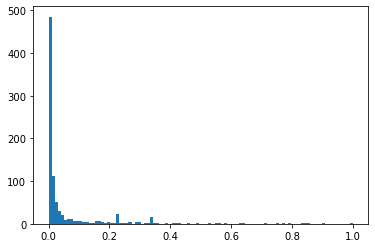

In [11]:
plt.hist(-np.log(df["p_value"].to_array()), bins = np.linspace(0,1,100));

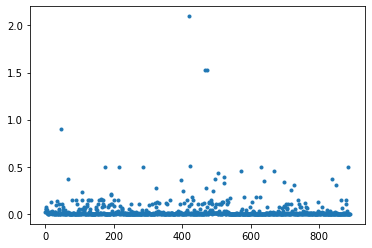

In [12]:
plt.plot(df["feature"].to_array(), -np.log10(df["p_value"].to_array()), ".");

In [13]:
show_manhattan_plot(df, 'chrom',  'pos', 'p_value')

Figure(id='1002', ...)

In [14]:
a = df["p_value"].to_array()
a.sort()
expect_p = np.linspace(0, 1, len(a))

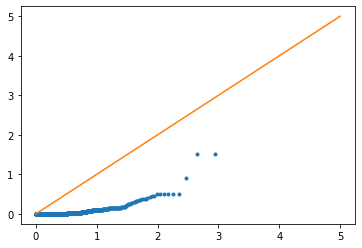

In [15]:
plt.plot(-np.log10(expect_p), -np.log10(a), '.')
plt.plot([0,5],[0,5])

In [27]:
df["e_value"] = np.linspace(0, 1, len(a))
df["p_s_value"] = a

show_qq_plot(df, 'e_value', 'p_s_value')

Figure(id='1246', ...)

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

output_notebook()

plot = figure()
plot.circle(-np.log10(expect_p+1e-10), -np.log10(a))

handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "qqplot"
push_notebook(handle=handle)

In [ ]:
!wget https://www.broadinstitute.org/files/shared/diabetes/scandinavs/DGI_chr3_pvals.txt

In [ ]:
pvals = []
with open('DGI_chr3_pvals.txt') as f:
    for r in f:
        r = r.strip()
        if r == 'PVAL':
            continue
        pvals.append(float(r))
pvals = np.array(pvals)

In [ ]:
pvals.sort()
expect_p = np.linspace(0, 1, len(pvals))

In [ ]:
plt.plot(-np.log10(expect_p), -np.log10(pvals), '.')
plt.plot([0,5],[0,5])

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
f#rom bokeh.models import Range1d

output_notebook()


plot = figure(plot_width=300, plot_height=300, 
              y_range=(0,5),
              x_range=(0,5))
plot.circle(-np.log10(expect_p+1e-10), -np.log10(pvals))
plot.line([0,5],[0,5])

handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "qqplot"
push_notebook(handle=handle)

In [ ]:
pvals